# DESCRIPCION

### Crear un model PNL de clasificación de texto de multiples etiquetas

la idea es entrenar un modelo por medio de una red neuronal recurrente LSTM simple de clasificación de texto con múltiples salidas. Desarrollaremos un modelo de clasificación de texto que analiza un comentario textual y predice múltiples etiquetas asociadas con el comentario.

El conjunto de datos contiene comentarios de las ediciones de la página de discusión de Wikipedia . Hay seis etiquetas de salida para cada comentario: 

* tóxico
* severo_tóxico
* obsceno
* amenaza
* insulto 
* hate.

Un comentario puede pertenecer a todas estas categorías o bien un subconjunto de estas categorías, lo que lo convierte en un problema de clasificación de múltiples etiquetas.

conjunto de datos

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

unicamente se usara el archivo train.csv que contiene aproximadamente 160000 comentarios

In [103]:
#IMPORTAR LIBRERIAS NECESARIAS
#===============================================================================#

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM,Input
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import CSVLogger,ModelCheckpoint,EarlyStopping

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# CARGAR ARCHIVO 
#========================================================================#

train = pd.read_csv('data/train.csv')
print(train.shape)
train.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
#ELIMINAR COMENTARIOS NULOS
#========================================================#

train = train.dropna()
train.shape

(159571, 8)

In [101]:
labels = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

## Visualización de datos

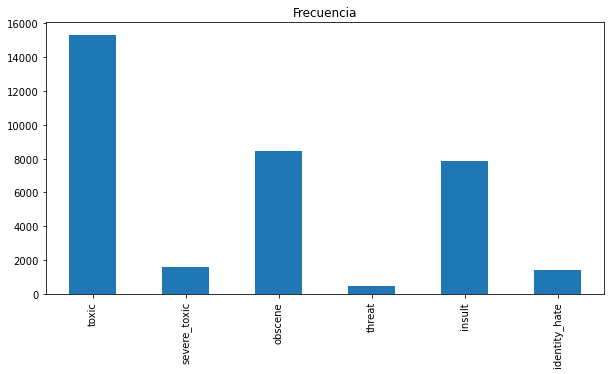

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

labels.sum(axis=0).plot.bar()
plt.title('Frecuencia')
plt.show()

In [21]:
def plotPie(df,col,labels):
    size_of_groups=[df[col].value_counts()[0],df[col].value_counts()[1]]
    colors = ['#17C37B','#F92969']

    print(df['toxic'].value_counts())
    my_pie,_,_ = plt.pie(size_of_groups,radius = 1.2,colors=colors,autopct="%.1f%%", labels=labels)
    plt.show()

TOXIC
0    144277
1     15294
Name: toxic, dtype: int64


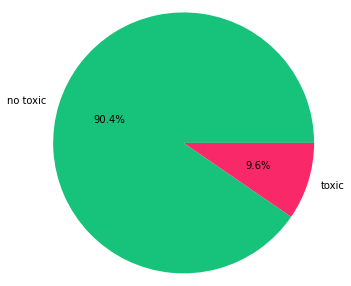



SEVERE_TOXIC
0    144277
1     15294
Name: toxic, dtype: int64


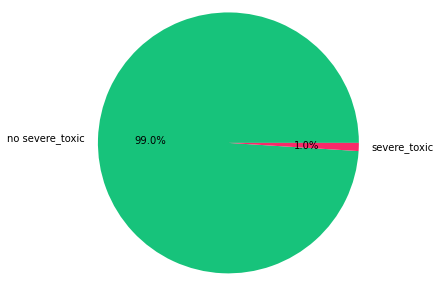



OBSCENE
0    144277
1     15294
Name: toxic, dtype: int64


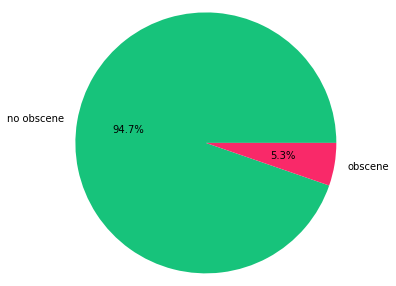



THREAT
0    144277
1     15294
Name: toxic, dtype: int64


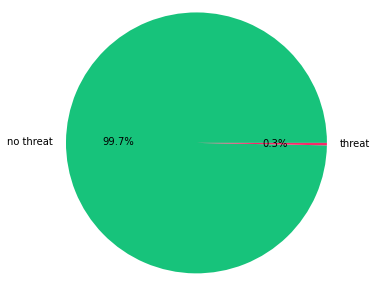



INSULT
0    144277
1     15294
Name: toxic, dtype: int64


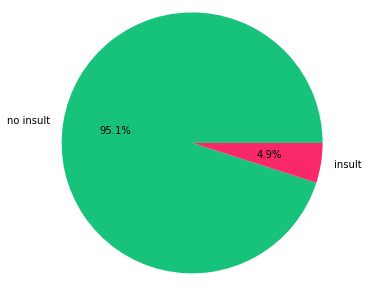



IDENTITY_HATE
0    144277
1     15294
Name: toxic, dtype: int64


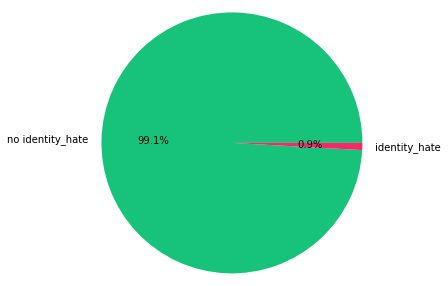

In [22]:
for t in labels:
    print(t.upper())
    print("==================================================================")
    plotPie(labels,t,['no '+t,t])
    print("\n")

## Data Cleaning

In [105]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [106]:
X = [preprocess_text(c) for c in list(train["comment_text"])]
y = labels.values

In [107]:
# DIVISION DE DATOS EN ENTRENAMIENTO Y PRUEBAS, RESPECTIVAMENTE
#=============================================================================#

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Realizando Embedding con Glove

In [108]:
NUM_WORDS = 5000

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)

train_tokenizer = tokenizer.texts_to_sequences(X_train)
test_tokenizer = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

train_padd = pad_sequences(train_tokenizer, padding='post', maxlen=maxlen)
test_padd = pad_sequences(test_tokenizer, padding='post', maxlen=maxlen)

In [109]:
# GUARDAR ARCHIVO TOKENIZER PARA USARLO PARA INFERENCIA
#===========================================================================#

import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### GENERANDO MATRIZ GLOVE

cargando el archivo glove y matriz que contiene los pesos para la capa embedding del modelo

In [110]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [111]:
embeddings_dictionary = dict()
#import archivo glove

glove_file = open('chatbot/glove/glove.6B.100d.txt', encoding="utf8")

In [112]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [113]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Creando Modelo

Para el primer modelo la salida sera una unica capa con el numero de clases que se quiere predecir que son 6

In [115]:
#ENTRADA
#===================================================================================#
inputs = Input(shape=(maxlen,))

#CAPA EMBEDDING
#vocab_size = tamaño de nuestro vocavulario
#weights = matriz de pesos previamente entrenados con glove
#ya que los pesos estan entrenados no necesita entrenarse nuevamente trainable = false
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputs)

#CAPA LSTM, CON FUNCION DE ACTIVACION TANH
LSTM_Layer_1 = LSTM(128,activation='tanh')(embedding_layer)

#SALIDA DEL MODELO CON CONTENDRA LAS PROBABILIDADES DE LAS 6 CLASES CON LA FUNCION DE ACTIVACION SIGMOID
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)

#CREANDO ENTRADAS Y SALIDAS DEL MODELO
model = Model(inputs=inputs, outputs=dense_layer_1)

#COMPILAR MODELO, OPTIMIZADOR ADAM CON TAZA DE APRENDIZAJE POR DEFECTO, BINARRY_CROSSENTROPY COMO FUNCION DE COSTO
#ACCURACY PARA EVALUAR NUESTRA RED CON CADA ITERACION
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

In [171]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________


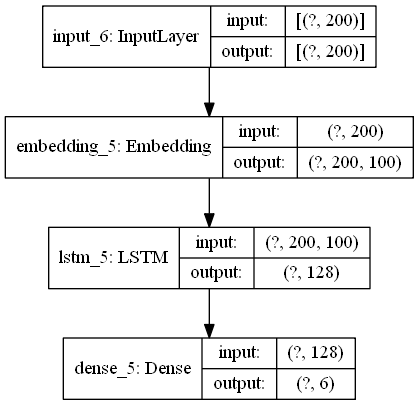

In [172]:
from keras.utils import plot_model
plot_model(model, to_file='sentiment_model.png', show_shapes=True, show_layer_names=True)

In [173]:
#DEFINIENDO CALLBACKS
filepath = 'checkpoints\cp-toxic_sen{epoch:02d}.hdf5'

#GUARDAR MODELO POR CADA ITERACION
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq='epoch')

#GUARDAR EL HISTORIAL DE APRENDIZAJE DEL MODELO
csv_logger = CSVLogger("checkpoints/model_history_sentiment_log.csv", append=True)

#EN CASO DE QUE NUESTRO MODELO NO MEJORE CON EL TIEMPO SE DETIENE
early_stopp = EarlyStopping(monitor='loss', patience=3)

callbacks = [checkpoint, csv_logger, early_stopp]

In [175]:
#ENTRENANDO EL MODELO
BATCH_SIZE = 130
EPOCHS = 10

history = model.fit(train_padd, 
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1, 
                    validation_data=(test_padd, y_test),
                    callbacks=callbacks)

Epoch 1/10
982/982 [==============================] - ETA: 0s - loss: 0.1412 - acc: 0.9768
Epoch 00001: loss improved from inf to 0.14117, saving model to checkpoints\cp-toxic_sen01.hdf5
982/982 [==============================] - 788s 803ms/step - loss: 0.1412 - acc: 0.9768 - val_loss: 0.1218 - val_acc: 0.9932
Epoch 2/10
982/982 [==============================] - ETA: 0s - loss: 0.0961 - acc: 0.9938
Epoch 00002: loss improved from 0.14117 to 0.09615, saving model to checkpoints\cp-toxic_sen02.hdf5
982/982 [==============================] - 789s 804ms/step - loss: 0.0961 - acc: 0.9938 - val_loss: 0.0647 - val_acc: 0.9941
Epoch 3/10
982/982 [==============================] - ETA: 0s - loss: 0.0609 - acc: 0.9878
Epoch 00003: loss improved from 0.09615 to 0.06087, saving model to checkpoints\cp-toxic_sen03.hdf5
982/982 [==============================] - 794s 808ms/step - loss: 0.0609 - acc: 0.9878 - val_loss: 0.0570 - val_acc: 0.9934
Epoch 4/10
982/982 [==============================] - ET

### RESULTADOS

Observamos que el modelo a pesar de ser simple, se adapta muy bien tanto en la exactitud de entrenamiento como en validación, probablemente por la naturaleza del dataset que se encuentra desbalanceado, como se vera mas adelante se necesitará de un umbral de decision por cada clase para mejorar nuestro modelo

## Graficando resultados

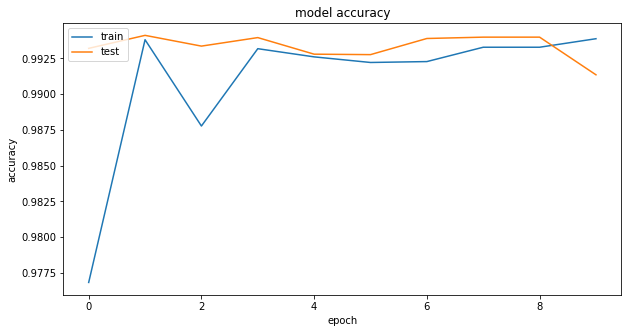

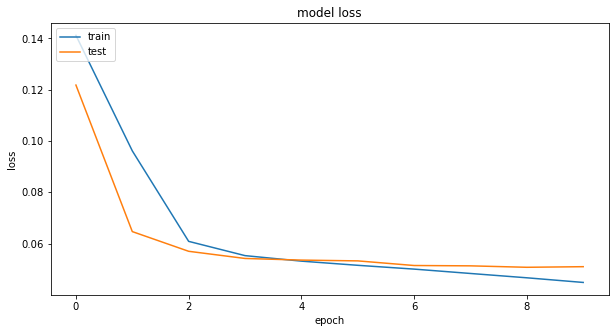

In [176]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Datos de prueba

con los datos de prueba, validaremos los resultados de nuestra red con distintas metricas

In [12]:
#IMPORTANDO LIBRERIAS PARA EVALUAR
#============================================================#

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [89]:
#CARGAR MODELO
#=====================================================================#
laded_model = load_model('checkpoints/cp-toxic_sen10.hdf5')

In [27]:
#PREDICCIONES
#====================================================================#
predictions = laded_model.predict(test_padd)

In [28]:
preds = predictions.copy()

In [322]:
model.evaluate(test_padd,y_test)

998/998 [==============================] - 107s 107ms/step - loss: 0.0510 - acc: 0.9914


[0.05100072920322418, 0.9913520216941833]

In [30]:
pres_df = pd.DataFrame(preds,columns=labels_class)

In [31]:
test_df = pd.DataFrame(y_test, columns=labels_class)

## Evaluar metricas

* 0->no pertenece a la clase
* 1->si pertenece a la clase

El objetivo del modelo es predecir que tan probable es, si un comentario pertenece o no a las clases evaluadas.
entonces nuestra metrica de intereces sera aumentar la precisión con la probabilidad de que un usuario es clasificado como insulto, amenaza, hate, etc. Se probaran distintos umbrales de desición diferentes para cada tipo de clase, dada la naturaleza del dataset que se encuentra desbalanceado, en su mayoría los comentarios estan etiquetados con 0, se prevee que los umbrales de desición sean pequeños.

In [33]:
def confussionMatrix(y_real,y_pred,labels):
    conf_matrix = confusion_matrix(y_real, y_pred)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print("verdaderos positivos:",conf_matrix[1][1])
    print("falsos positivos:",conf_matrix[0][1])
    print("verdaderos negativos:",conf_matrix[0][0])
    print("falsos negativos:",conf_matrix[1][0])
    print(getMetrics(y_real,y_pred))

def getMetrics(y_real,y_pred):
    return {
        "Accuracy": metrics.accuracy_score(y_real, y_pred),
        "Precision": metrics.precision_score(y_real, y_pred),
        "Recall:": metrics.recall_score(y_real, y_pred),
        "F1_Score:":metrics.f1_score(y_real, y_pred)
    }

===========================TOXIC MATRIX=========================================


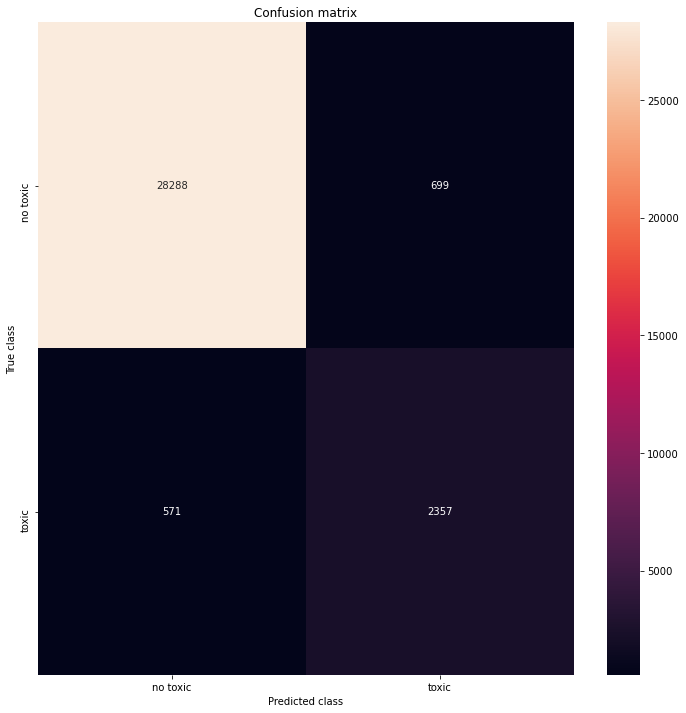

verdaderos positivos: 2357
falsos positivos: 699
verdaderos negativos: 28288
falsos negativos: 571
{'Accuracy': 0.960206799310669, 'Precision': 0.7712696335078534, 'Recall:': 0.8049863387978142, 'F1_Score:': 0.7877673796791443}


In [81]:
print("===========================TOXIC CLASS MATRIX=========================================")
test_df["pred_toxic"] = np.where(pres_df['toxic']>0.4,1,0)
confussionMatrix(test_df['pred_toxic'],test_df['toxic'],['no toxic','toxic'])


===========================SEVERE TOXIC CLASS MATRIX=========================================


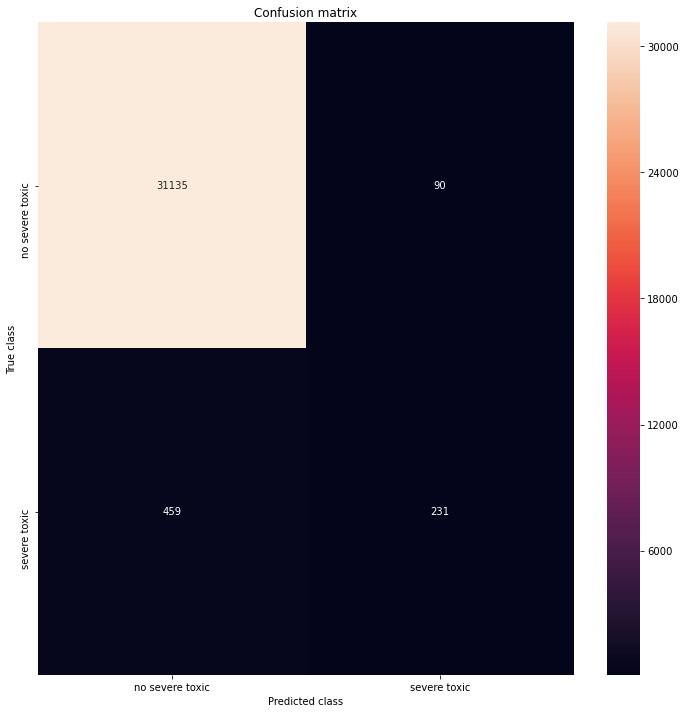

verdaderos positivos: 231
falsos positivos: 90
verdaderos negativos: 31135
falsos negativos: 459
{'Accuracy': 0.9827980573398089, 'Precision': 0.719626168224299, 'Recall:': 0.3347826086956522, 'F1_Score:': 0.456973293768546}


In [82]:
print("===========================SEVERE TOXIC CLASS MATRIX=========================================")
test_df["pred_severe_toxic"] = np.where(pres_df['severe_toxic']>0.15,1,0)
confussionMatrix(test_df['pred_severe_toxic'],test_df['severe_toxic'],['no severe toxic','severe toxic'])

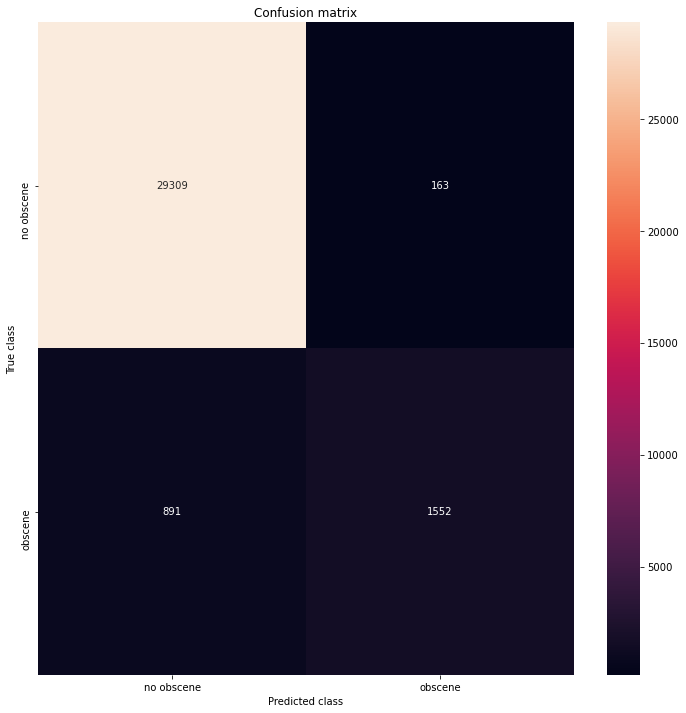

verdaderos positivos: 1552
falsos positivos: 163
verdaderos negativos: 29309
falsos negativos: 891
{'Accuracy': 0.9669747767507442, 'Precision': 0.9049562682215744, 'Recall:': 0.6352844862873516, 'F1_Score:': 0.7465127465127466}


In [60]:
print("===========================OBSCENE CLASS MATRIX=========================================")
test_df["pred_obscene"] = np.where(pres_df['obscene']>0.15,1,0)
confussionMatrix(test_df['pred_obscene'],test_df['obscene'],['no obscene','obscene'])

===========================SEVERE THREAT CLASS MATRIX=========================================


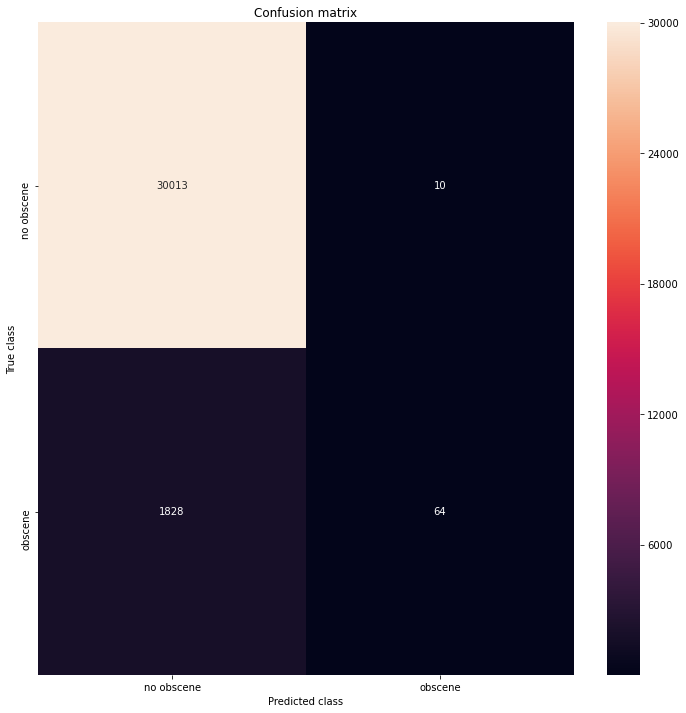

verdaderos positivos: 64
falsos positivos: 10
verdaderos negativos: 30013
falsos negativos: 1828
{'Accuracy': 0.9424095253015823, 'Precision': 0.8648648648648649, 'Recall:': 0.03382663847780127, 'F1_Score:': 0.06510681586978637}


In [83]:
print("===========================SEVERE THREAT CLASS MATRIX=========================================")
test_df["pred_threat"] = np.where(pres_df['threat']>0.01,1,0)
confussionMatrix(test_df['pred_threat'],test_df['threat'],['no obscene','obscene'])

===========================SEVERE INSULT CLASS MATRIX=========================================


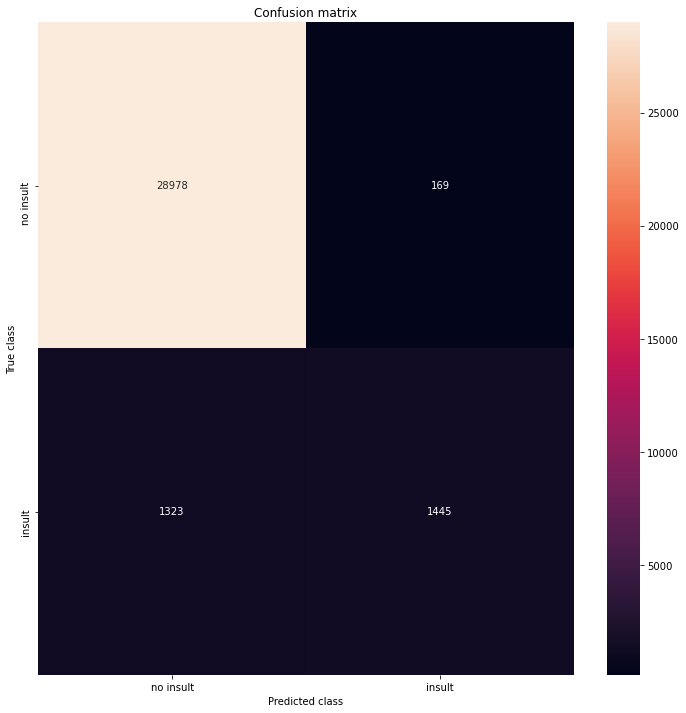

verdaderos positivos: 1445
falsos positivos: 169
verdaderos negativos: 28978
falsos negativos: 1323
{'Accuracy': 0.9532508224972583, 'Precision': 0.8952912019826518, 'Recall:': 0.5220375722543352, 'F1_Score:': 0.6595162026471931}


In [84]:
print("===========================SEVERE INSULT CLASS MATRIX=========================================")
test_df["pred_insult"] = np.where(pres_df['insult']>0.1,1,0)
confussionMatrix(test_df['pred_insult'],test_df['insult'],['no insult','insult'])

===========================SEVERE IDENTITY HATE CLASS MATRIX=========================================


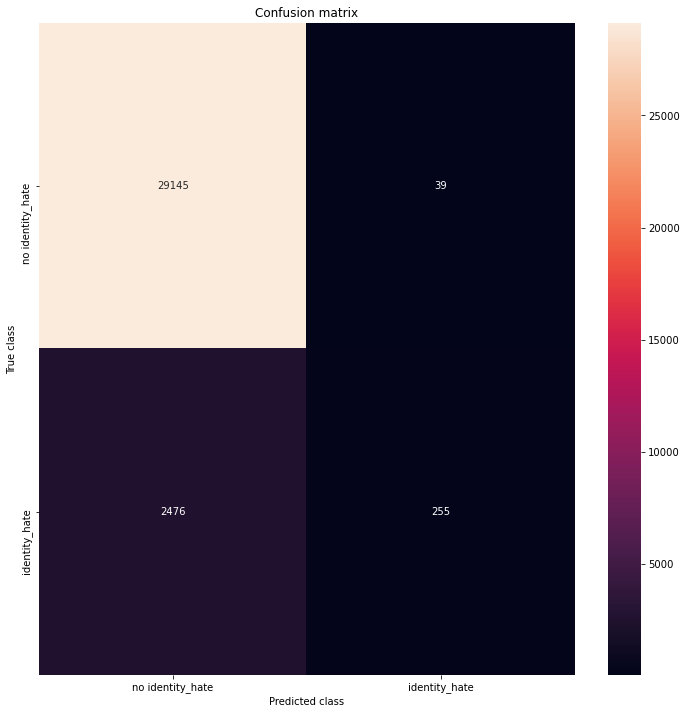

verdaderos positivos: 255
falsos positivos: 39
verdaderos negativos: 29145
falsos negativos: 2476
{'Accuracy': 0.9211969293435689, 'Precision': 0.8673469387755102, 'Recall:': 0.09337239106554375, 'F1_Score:': 0.16859504132231404}


In [85]:
print("===========================SEVERE IDENTITY HATE CLASS MATRIX=========================================")
test_df["pred_identity_hate"] = np.where(pres_df['identity_hate']>0.01,1,0)
confussionMatrix(test_df['pred_identity_hate'],test_df['identity_hate'],['no identity_hate','identity_hate'])

## CONCLUSIONES

El modelo mantiene muy buena exactitud y aumentamos la precisión en identificar los comentarios etiquetados como 1. en todas las clases necesarias.